Note: this notebook contains a prediction for positive selection in a Gambian population us

In [1]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import pymc3

import tensorflow as tf
from tensorflow import keras
from keras import models, layers, activations, optimizers, regularizers
from keras.utils.vis_utils import plot_model
from keras.models import load_model

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix
import pydot # optional, but required by keras to plot the model

In [2]:
#Import ImaGene
%run -i /data/home/bt18241/research-project/ImaGene/ImaGene.py

# Reading the _HBB_ VCF file and storing it in ImaGene file

The number of samples of chromosomal copies is specified. This is twice the number for diploid organisms.

In [3]:
file_hbb = ImaFile(nr_samples=226, VCF_file_name='/data/home/bt18241/research-project/ImaGene/first_simulation/hbc_gambian.vcf')


Read the VCF file to create  an _ImaGene_ object. This also results in a matrix of haplotypes being generated.

In [4]:
gene_hbb = file_hbc.read_VCF()

Look at the data stored in this object

In [5]:
gene_hbb.summary()

An object of 1 image(s)
Rows: min 226, max 226, mean 226.000000, std 0.000000
Columns: min 3225, max 3225, mean 3225.000000, std 0.000000


0

There is 1 image with 226 rows, representing the number of sampled chromosomal copies.

There are 3225 columns which is the number of all the genomic positions reported.

Remove rare variants as they are not informative along with monomorphic and singletons for  derived alleles.

In [6]:
gene_hbb.filter_freq(0.01)

0

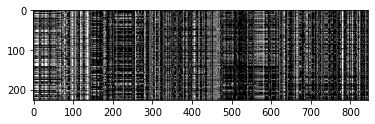

0

In [7]:
gene_hbb.plot()

Rows are arranged by their frequency. The most common haplotypes are at the top. This is can be done as the order of the rows are arbitrary.

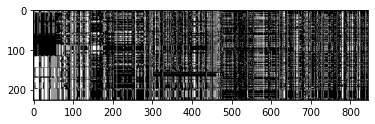

0

In [8]:
gene_hbb.sort('rows_freq')
gene_hbb.plot()

The colours of the images is change so that black pixels represent derived alleles. This is the standard representation of genomic data.  

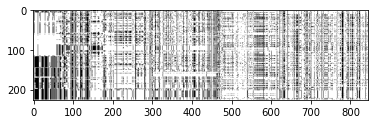

An object of 1 image(s)
Rows: min 226, max 226, mean 226.000000, std 0.000000
Columns: min 845, max 845, mean 845.000000, std 0.000000


0

In [9]:
gene_hbb.convert(flip=True)
gene_hbb.plot()
gene_hbb.summary()

The number of columns reduced from ~3000 to 845 columns represent the number of retained SNPs.

ImaGene object is then saved to the working `path` directory

In [10]:
path = '/data/scratch/bt18241/Data/'

In [11]:
gene_hbb.save(file=path + 'gene_hbb')

0

Load ImaGene object

In [12]:
gene_hbb = load_imagene(file=path + 'gene_hbb')

# Evaluating training

Load the training model

In [14]:
model = load_model(path + 'hbb_tenessen_gambian_model_h5')

2022-08-07 17:05:13.144291: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load the saved network

In [15]:
hbb_net_tennessen = load_imanet(path + 'hbb_net_tennessen_binary')

Evaluate the training on the testing dataset which is the last batch of simulated data

In [16]:
path_sim = '/data/scratch/bt18241/Binary/hbc_binary_tennessen_80kbp_200'


In [17]:
#The same preprocessing is done to match the real genomic data
i = 10
file_sim = ImaFile(simulations_folder=path_sim + '/Simulations' + str(i), nr_samples=202, model_name='Tennessen')
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

gene_sim_test.filter_freq(0.01)
gene_sim_test.sort('rows_freq')
gene_sim_test.resize((226, 845))
gene_sim_test.convert(flip=True)

rnd_idx = get_index_random(gene_sim_test) # no need to create this extra variable
gene_sim_test.subset(rnd_idx)

gene_sim_test.targets = to_binary(gene_sim_test.targets);

Report loss and accuracy on the testing set

In [18]:
model = load_model(path + 'hbb_tenessen_gambian_model_h5')

In [20]:
hbb_net_tennessen.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)
print(hbb_net_tennessen.test) # [loss, accuracy]

[0.8422781825065613, 0.8665000200271606]


Plot the confusion matrix after predicting the responses from the testing data.

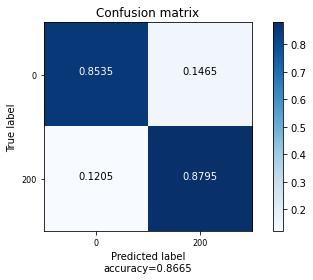

0

In [21]:
hbb_net_tennessen.predict(gene_sim_test, model)
hbb_net_tennessen.plot_cm(gene_sim_test.classes, text=True)

# Deploy the trained network onto the _HBB_ gene

Since a binary classification is carried out, predictions close to zero suggests neutral and predictions close to one suggest selection.

In [22]:
print(model.predict(gene_hbb.data, batch_size=None)[0][0])

0.008997649


This result shows that there is strong predictions for neutral for the _HBB_ gene.